##1.Data Preprocessing

Au sein du dossier test, train et valid, nous avons des images au format jpg et un fichier csv nommé _annotations.csv qui contient les colonnes suivantes :

-	filename : Nom de l'image annotée.
- 	width et height : Dimensions de l'image.
-	class : Classe d'objet (mask et no-mask).
-	xmin, ymin, xmax, ymax : Coordonnées du rectangle englobant l'objet dans l'image.


### 1.1 Unzip

In [1]:
import zipfile
import os

zip_path = r"C:\Users\jinan\OneDrive\Documents\A5_DIA2\ML_CV\Projet\Mask Wearing.v4-raw.tensorflow.zip"
output_dir = r"C:\Users\jinan\OneDrive\Documents\A5_DIA2\ML_CV\Projet\mask_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f"Content extracted in : {output_dir}")


Content extracted in : C:\Users\jinan\OneDrive\Documents\A5_DIA2\ML_CV\Projet\mask_dataset


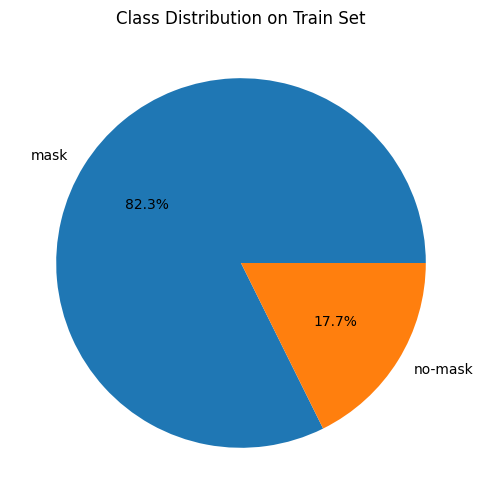

In [13]:
#Class statistics:

import pandas as pd
import matplotlib.pyplot as plt

annotations_file = r"C:\Users\jinan\OneDrive\Documents\A5_DIA2\ML_CV\Projet\mask_dataset\train\_annotations.csv"

# Calculate class counts and percentages
class_counts = data["class"].value_counts()
class_percentages = (class_counts / class_counts.sum()) * 100

# Plot the pie chart with percentages
plt.figure(figsize=(8, 6))
class_counts.plot(kind="pie", autopct=lambda p: f'{p:.1f}%', title="Class Distribution on Train Set")
plt.ylabel("")  # Remove the default 'class' label for cleaner display
plt.show()

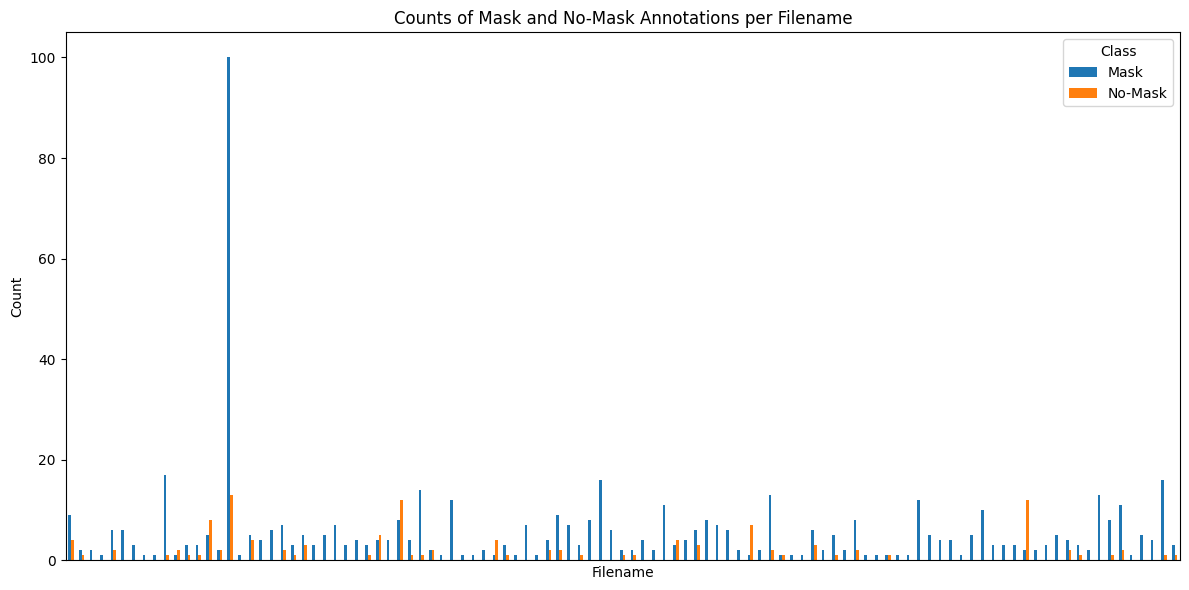

In [3]:
import matplotlib.pyplot as plt

# Count the number of each class Mask, No Mask per filename again but focus on absolute counts
class_counts = data.groupby(['filename', 'class']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(12, 6))
class_counts.plot(kind='bar', stacked=False, ax=ax)
ax.set_title('Counts of Mask and No-Mask Annotations per Filename')
ax.set_xlabel('Filename')
ax.set_ylabel('Count')
ax.legend(['Mask', 'No-Mask'], title="Class")
plt.xticks(ticks=[], labels=[], rotation=90)  
plt.tight_layout()
plt.show()


62 0


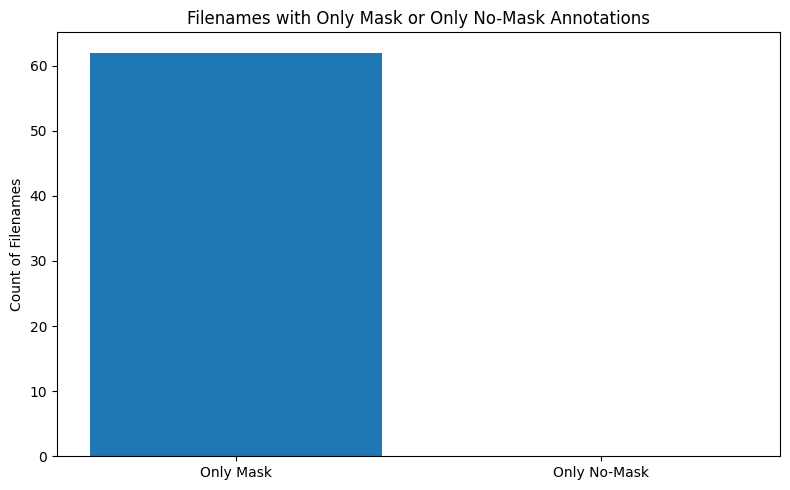

In [4]:
# Identify filenames with only "mask" or "no-mask"
unique_class_per_file = data.groupby('filename')['class'].unique()

only_mask = unique_class_per_file.apply(lambda x: len(x) == 1 and 'mask' in x).sum()
only_no_mask = unique_class_per_file.apply(lambda x: len(x) == 1 and 'no-mask' in x).sum()
print(only_mask, only_no_mask)

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(['Only Mask', 'Only No-Mask'], [only_mask, only_no_mask])
ax.set_title('Filenames with Only Mask or Only No-Mask Annotations')
ax.set_ylabel('Count of Filenames')
plt.tight_layout()
plt.show()


### 1.2 Conversion of annotations to YOLO format

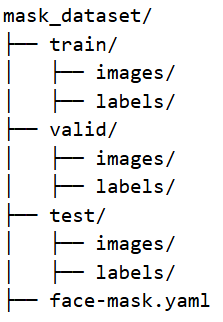

In [5]:
import pandas as pd
import os
import shutil

#Create the necessary structure for YOLOv5

base_dir =  r"C:\Users\jinan\OneDrive\Documents\A5_DIA2\ML_CV\Projet\mask_dataset"

subdirs = ["train", "valid", "test"]

class_mapping = {
    "mask": 0,
    "no-mask": 1
}

for subdir in subdirs:
    images_src_dir = os.path.join(base_dir, subdir)  
    annotations_file = os.path.join(images_src_dir, "_annotations.csv")  
    images_dst_dir = os.path.join(base_dir, subdir, "images")  
    labels_dst_dir = os.path.join(base_dir, subdir, "labels") 

    os.makedirs(images_dst_dir, exist_ok=True)
    os.makedirs(labels_dst_dir, exist_ok=True)

    for file in os.listdir(images_src_dir):
        if file.endswith(".jpg") or file.endswith(".png"):
            shutil.move(os.path.join(images_src_dir, file), os.path.join(images_dst_dir, file))

    if os.path.exists(annotations_file):
        annotations = pd.read_csv(annotations_file)

        for filename, group in annotations.groupby("filename"):
            image_width = group.iloc[0]["width"]
            image_height = group.iloc[0]["height"]

            txt_filename = os.path.splitext(filename)[0] + ".txt"
            txt_path = os.path.join(labels_dst_dir, txt_filename)

            with open(txt_path, "w") as f:
                for _, row in group.iterrows():

                    class_name = row["class"]
                    if class_name in class_mapping:
                        class_id = class_mapping[class_name]
                    else:
                        print(f"Unknown class '{class_name}' in file {annotations_file}")
                        continue  

                    # Calculer les coordonnées normalisées YOLO
                    center_x = (row["xmin"] + row["xmax"]) / 2 / image_width
                    center_y = (row["ymin"] + row["ymax"]) / 2 / image_height
                    box_width = (row["xmax"] - row["xmin"]) / image_width
                    box_height = (row["ymax"] - row["ymin"]) / image_height

                    # Écrire les annotations dans le fichier texte
                    f.write(f"{class_id} {center_x} {center_y} {box_width} {box_height}\n")

        print(f"Annotations converted for the folder '{subdir}' and saved in : {labels_dst_dir}")

Annotations converted for the folder 'train' and saved in : C:\Users\jinan\OneDrive\Documents\A5_DIA2\ML_CV\Projet\mask_dataset\train\labels
Annotations converted for the folder 'valid' and saved in : C:\Users\jinan\OneDrive\Documents\A5_DIA2\ML_CV\Projet\mask_dataset\valid\labels
Annotations converted for the folder 'test' and saved in : C:\Users\jinan\OneDrive\Documents\A5_DIA2\ML_CV\Projet\mask_dataset\test\labels


In [6]:
#Add file face-mask.yaml at the root of the folder mask_dataset

yaml_file_path = r"C:\Users\jinan\OneDrive\Documents\A5_DIA2\ML_CV\Projet\mask_dataset\face-mask.yaml"

yaml_content = """
train: C:/Users/jinan/OneDrive/Documents/A5_DIA2/ML_CV/Projet/mask_dataset/train
val: C:/Users/jinan/OneDrive/Documents/A5_DIA2/ML_CV/Projet/mask_dataset/valid
test: C:/Users/jinan/OneDrive/Documents/A5_DIA2/ML_CV/Projet/mask_dataset/test

nc: 2
names: ['mask', 'no-mask']
"""

os.makedirs(os.path.dirname(yaml_file_path), exist_ok=True)

with open(yaml_file_path, "w") as f:
    f.write(yaml_content)

print(f"YAML file created : {yaml_file_path}")


YAML file created : C:\Users\jinan\OneDrive\Documents\A5_DIA2\ML_CV\Projet\mask_dataset\face-mask.yaml


## 2. Exploratory Data Analysis (EDA)

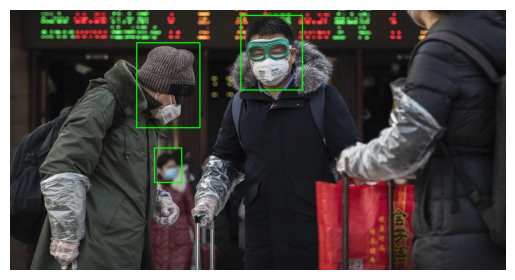

In [7]:
import cv2
import matplotlib.pyplot as plt

# Displaying an image (example) with bounding boxes
image_path = r"C:/Users/jinan/OneDrive/Documents/A5_DIA2/ML_CV/Projet/mask_dataset/test/images/0_Concern-In-China-As-Mystery-Virus-Spreads_jpg.rf.5633f5fe7a9b926101b7fc16615dfb6a.jpg"
label_path = r"C:/Users/jinan/OneDrive/Documents/A5_DIA2/ML_CV/Projet/mask_dataset/test/labels/0_Concern-In-China-As-Mystery-Virus-Spreads_jpg.rf.5633f5fe7a9b926101b7fc16615dfb6a.txt"

img = cv2.imread(image_path)
with open(label_path, "r") as f:
    for line in f:
        class_id, center_x, center_y, width, height = map(float, line.split())
        h, w, _ = img.shape
        x1 = int((center_x - width / 2) * w)
        y1 = int((center_y - height / 2) * h)
        x2 = int((center_x + width / 2) * w)
        y2 = int((center_y + height / 2) * h)
        color = (0, 255, 0) if class_id == 0 else (0, 0, 255)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


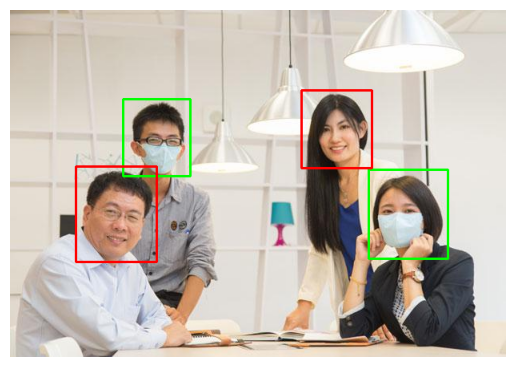

In [8]:
import cv2
import matplotlib.pyplot as plt

# Displaying an other image (example) with bounding boxes
image_path = r"C:/Users/jinan/OneDrive/Documents/A5_DIA2/ML_CV/Projet/mask_dataset/train/images/0_10725_jpg.rf.cde494b05911f991c3cc31c8670044b9.jpg"
label_path = r"C:/Users/jinan/OneDrive/Documents/A5_DIA2/ML_CV/Projet/mask_dataset/train/labels/0_10725_jpg.rf.cde494b05911f991c3cc31c8670044b9.txt"

img = cv2.imread(image_path)
with open(label_path, "r") as f:
    for line in f:
        class_id, center_x, center_y, width, height = map(float, line.split())
        h, w, _ = img.shape
        x1 = int((center_x - width / 2) * w)
        y1 = int((center_y - height / 2) * h)
        x2 = int((center_x + width / 2) * w)
        y2 = int((center_y + height / 2) * h)
        color = (0, 255, 0) if class_id == 0 else (0, 0, 255)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


## 3. YOLOv5 for face mask detection

### Clone the github to install YOLOv5 and his dependencies

In [9]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

c:\Users\jinan\OneDrive\Documents\A5_DIA2\ML_CV\Projet\yolov5


Cloning into 'yolov5'...
c:\Users\jinan\OneDrive\Documents\A5_DIA2\ML_CV\Projet\env_yolo\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [10]:
!pip install -qr yolov5/requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'yolov5/requirements.txt'

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## **Start the training**

In [11]:
#Start the training using the train.py script from YOLOv5 

!python train.py --img 640 --batch 16 --epochs 100 --data C:/Users/jinan/OneDrive/Documents/A5_DIA2/ML_CV/Projet/mask_dataset/face-mask.yaml --weights yolov5s.pt --cache

train: weights=yolov5s.pt, cfg=, data=C:/Users/jinan/OneDrive/Documents/A5_DIA2/ML_CV/Projet/mask_dataset/face-mask.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data\hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs\train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 
YOLOv5  v7.0-392-gf003c3df Python-3.12.0 torch-2.5.1+cpu CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_l

#### Paramètres :
- `--img 640` : Définit la taille des images d'entrée (640x640 pixels).
- `--batch 16` : Taille du batch pour l'entraînement
- `--epochs 100` : Nombre d'époques
- `--data` : Chemin vers le fichier YAML (`face-mask.yaml`).
- `--weights yolov5s.pt` : Utilise le modèle pré-entraîné YOLOv5s comme point de départ


### Suivre l'entraînement

Pendant l'entraînement, YOLOv5 génère des graphiques et des métriques :
- **Perte** : Indique si le modèle apprend correctement.
- **mAP** : Moyenne de la précision (indique les performances globales du modèle).
- Les fichiers de sortie sont enregistrés dans `runs/train/exp`.


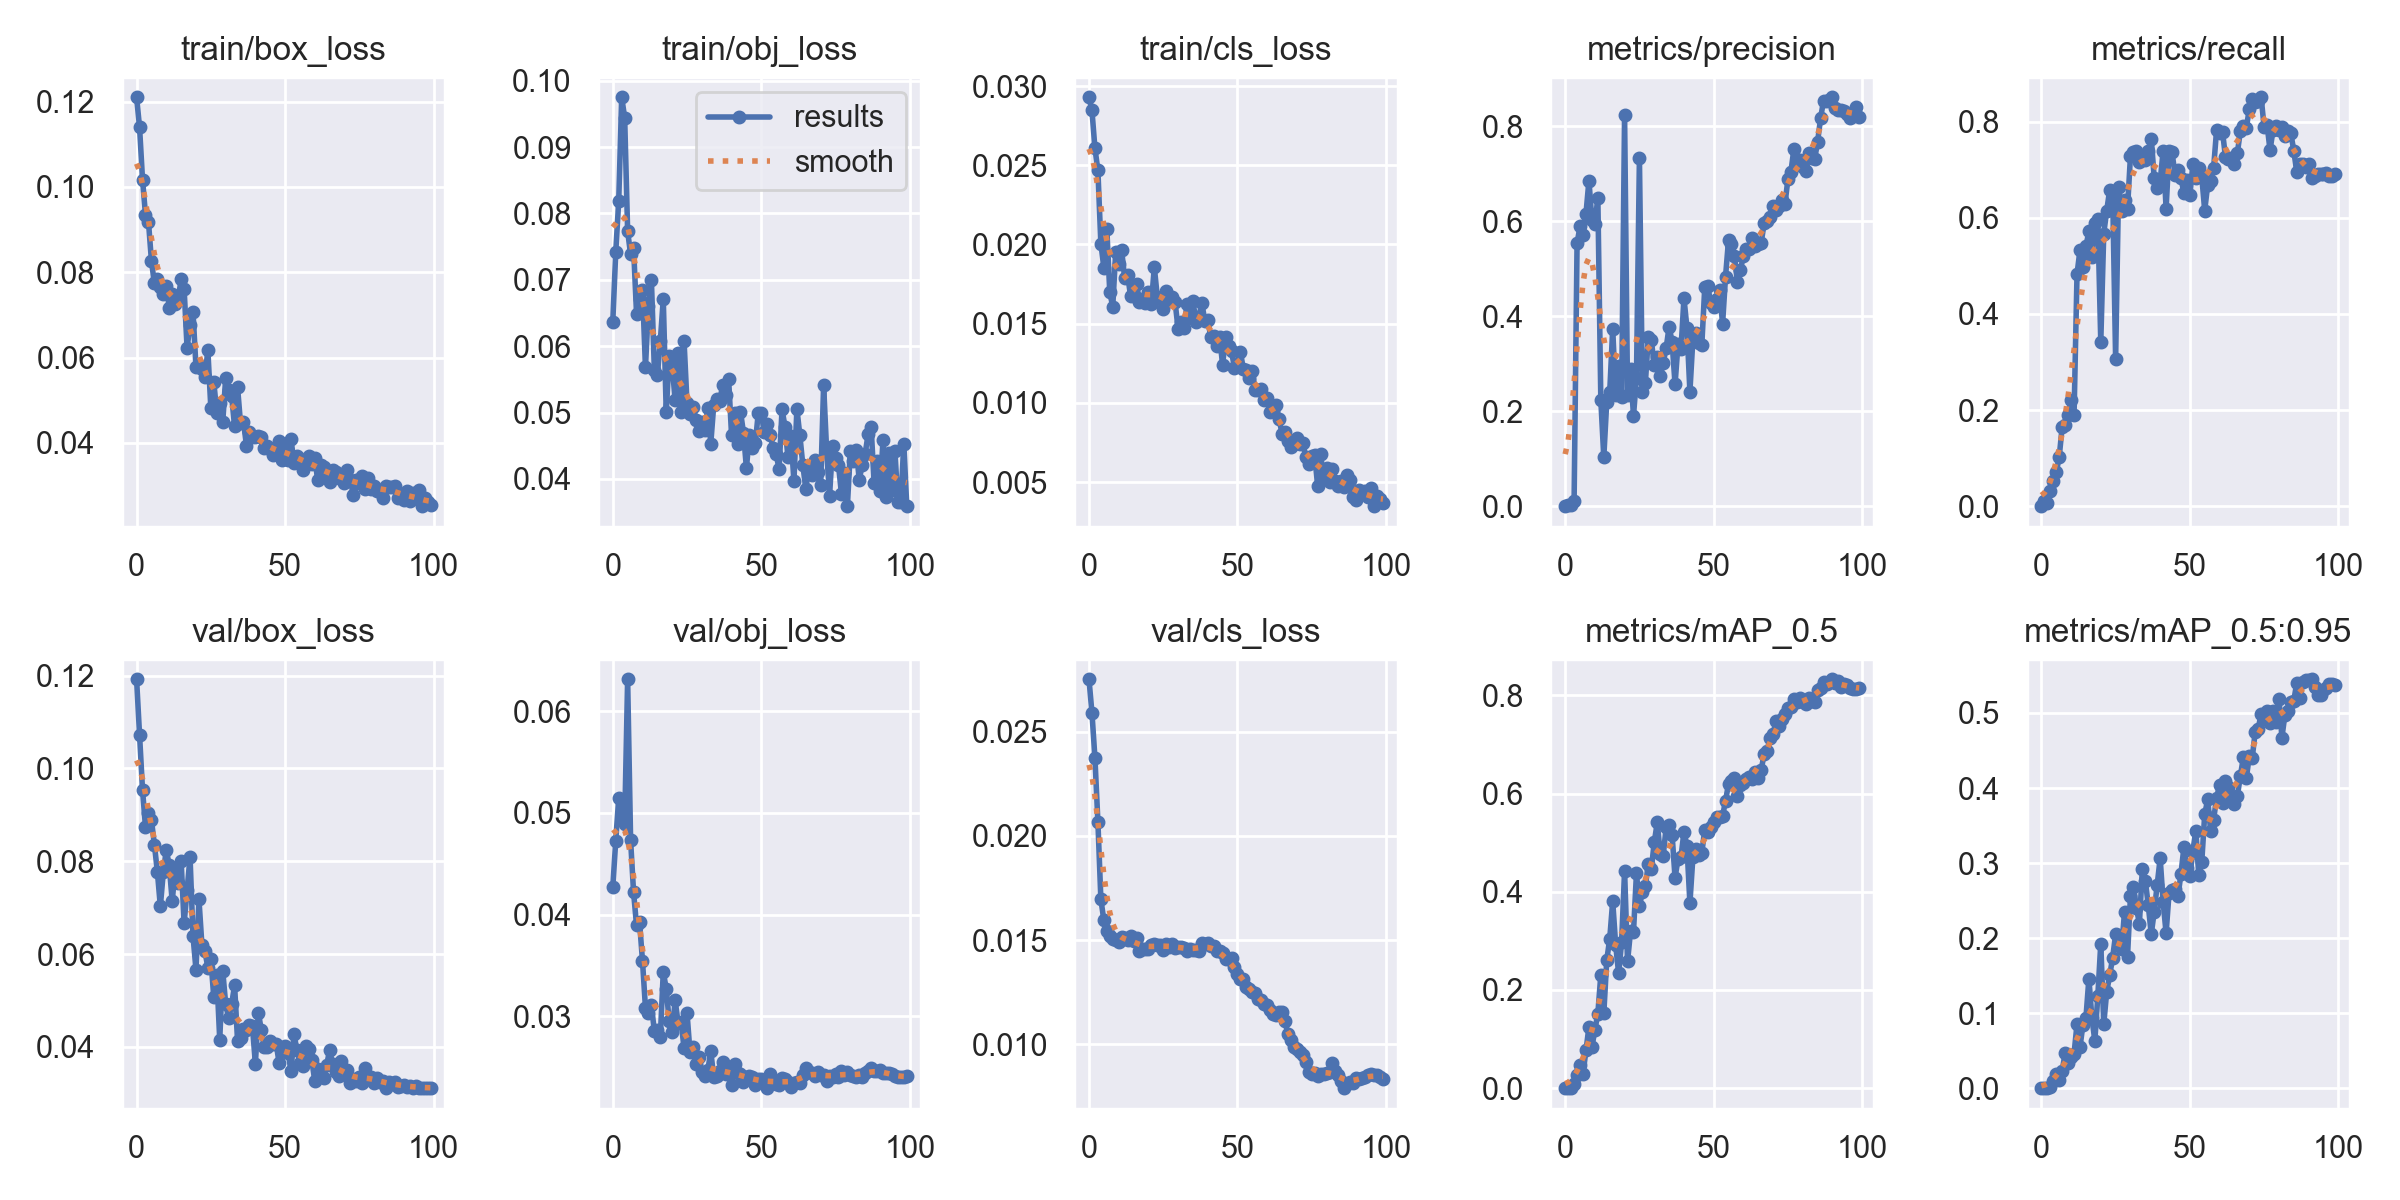

In [16]:
from IPython.display import Image
display(Image(filename=r"C:\Users\jinan\OneDrive\Documents\A5_DIA2\ML_CV\Projet\yolov5\runs\train\exp\results.png"))

#### Metrics Evolution over epochs

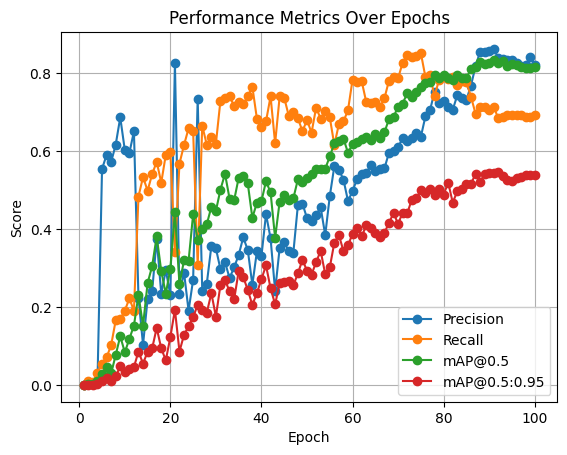

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

results_file = r"C:\Users\jinan\OneDrive\Documents\A5_DIA2\ML_CV\Projet\yolov5\runs\train\exp\results.csv"
results = pd.read_csv(results_file)

# clean columns names
results.columns = results.columns.str.strip()

epochs = results.index + 1  # Index for epcohs

plt.plot(epochs, results['metrics/precision'], label='Precision', marker='o')
plt.plot(epochs, results['metrics/recall'], label='Recall', marker='o')
plt.plot(epochs, results['metrics/mAP_0.5'], label='mAP@0.5', marker='o')
plt.plot(epochs, results['metrics/mAP_0.5:0.95'], label='mAP@0.5:0.95', marker='o')

plt.title('Performance Metrics Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()


- Loss Evolution over epochs During Training
- Total Loss Comparison (Train and validation)

In [9]:
#!tensorboard --logdir runs/train --bind_all

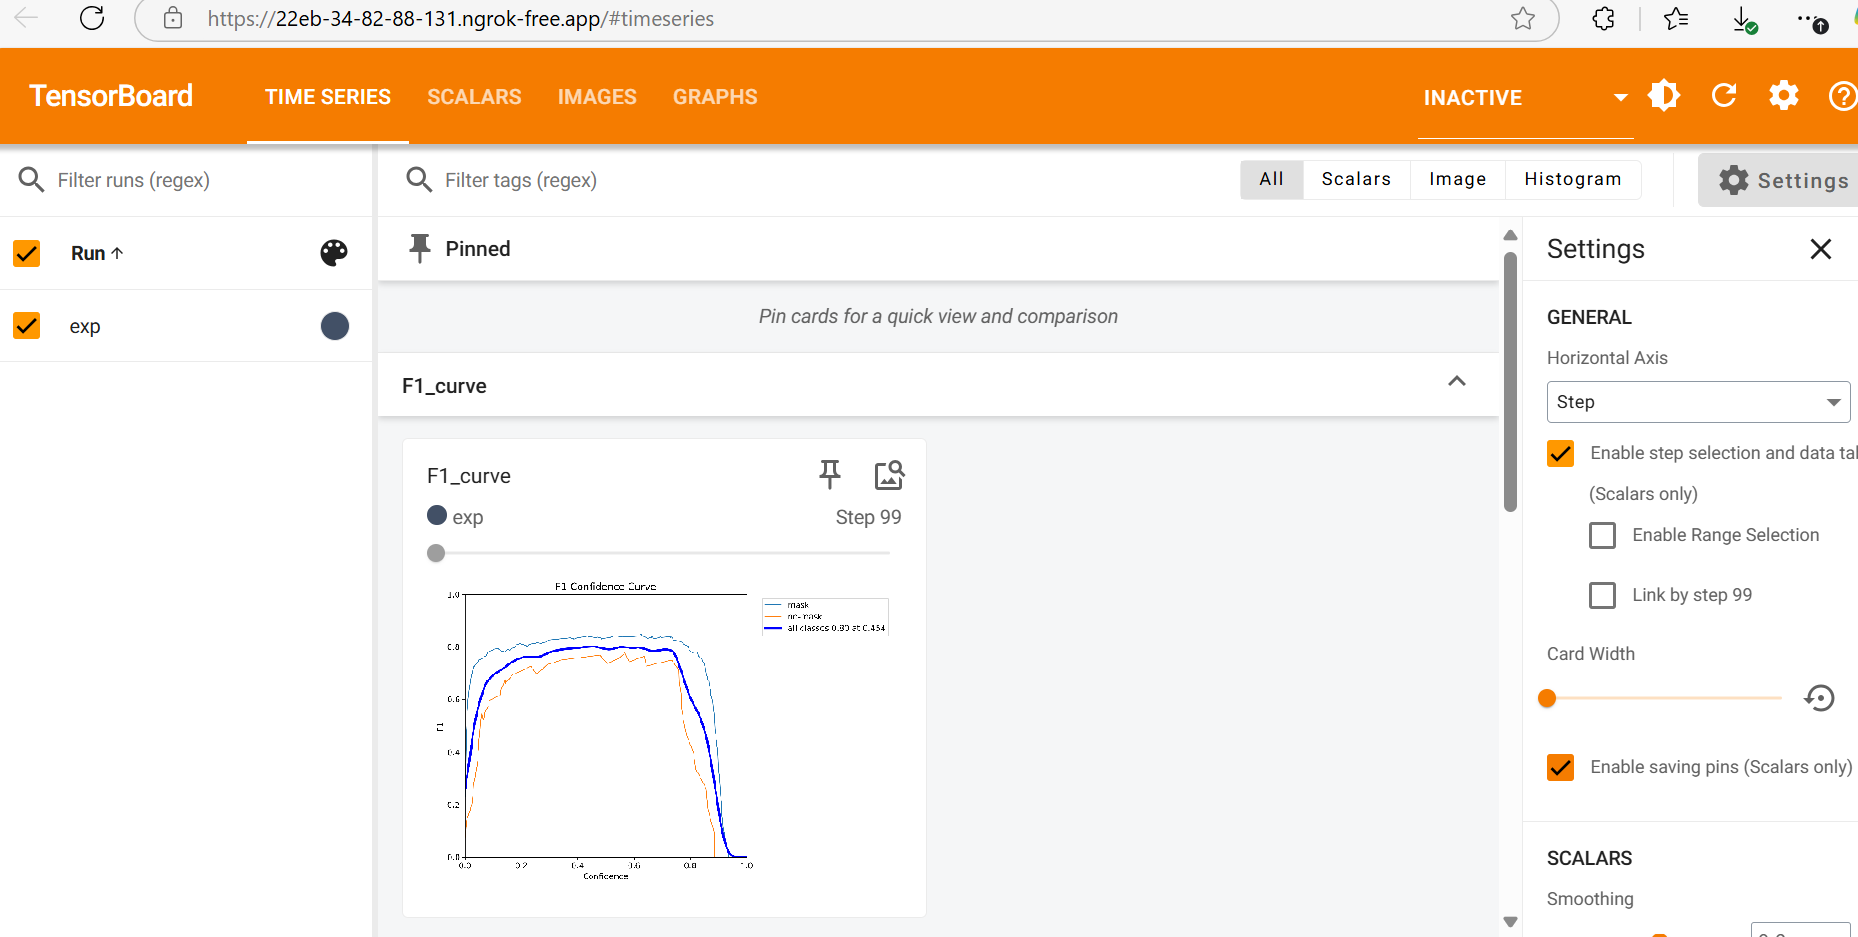

## **Test the model**

In [21]:
!python C:/Users/jinan/OneDrive/Documents/A5_DIA2/ML_CV/Projet/yolov5/detect.py --source C:/Users/jinan/OneDrive/Documents/A5_DIA2/ML_CV/Projet/mask_dataset/test/images --weights runs/train/exp/weights/best.pt --img 640 --conf 0.5 --save-txt --save-conf

detect: weights=['runs/train/exp/weights/best.pt'], source=C:/Users/jinan/OneDrive/Documents/A5_DIA2/ML_CV/Projet/mask_dataset/test/images, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  v7.0-392-gf003c3df Python-3.12.0 torch-2.5.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/15 C:\Users\jinan\OneDrive\Documents\A5_DIA2\ML_CV\Projet\mask_dataset\test\images\0_Concern-In-China-As-Mystery-Virus-Spreads_jpg.rf.5633f5fe7a9b926101b7fc16615dfb6a.jpg: 352x640 2 masks, 204.8ms
image 2/15 C:\Users\jinan\OneDrive\Documents\A5_DIA2\ML_CV\Projet\mask_dataset\t

#### Paramètres :
- `--source` : Chemin vers les images à tester.
- `--weights` : Chemin vers le meilleur modèle généré (fichier `best.pt`).
- `--conf 0.5` : Seuil de confiance pour les détections.
- `--save-txt` : Sauvegarde les prédictions en texte.
- `--save-conf` : Sauvegarde les scores de confiance des détections.

### Visualize the results

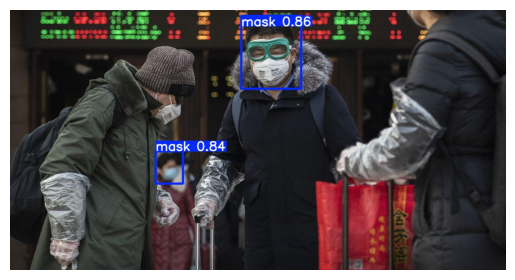

In [24]:
# SCORING (seuil de confiance de la prédiction) AND LABEL (mask et no-mask)
import cv2
import matplotlib.pyplot as plt

image_path = r"C:\Users\jinan\OneDrive\Documents\A5_DIA2\ML_CV\Projet\yolov5\runs\detect\exp2\0_Concern-In-China-As-Mystery-Virus-Spreads_jpg.rf.5633f5fe7a9b926101b7fc16615dfb6a.jpg"
img = cv2.imread(image_path)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


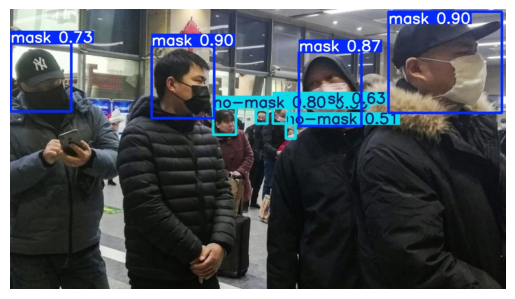

In [25]:
import cv2
import matplotlib.pyplot as plt

image_path = r"C:\Users\jinan\OneDrive\Documents\A5_DIA2\ML_CV\Projet\yolov5\runs\detect\exp2\the-first-day-of-wuhan-s-closure-some-people-fled-some-panicked_jpg.rf.51ed69bf8d327d93b429a08581f6dea0.jpg"
img = cv2.imread(image_path)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


### Test the model on a new image

In [29]:
from PIL import Image

!python C:/Users/jinan/OneDrive/Documents/A5_DIA2/ML_CV/Projet/yolov5/detect.py --source C:/Users/jinan/OneDrive/Documents/A5_DIA2/ML_CV/Projet/ImageTest.jpg \
                 --weights runs/train/exp/weights/best.pt \
                 --img 640 --conf 0.5 --save-txt --save-conf



detect: weights=['runs/train/exp/weights/best.pt'], source=C:/Users/jinan/OneDrive/Documents/A5_DIA2/ML_CV/Projet/ImageTest.jpg, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  v7.0-392-gf003c3df Python-3.12.0 torch-2.5.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 C:\Users\jinan\OneDrive\Documents\A5_DIA2\ML_CV\Projet\ImageTest.jpg: 352x640 4 masks, 4 no-masks, 119.8ms
Speed: 2.7ms pre-process, 119.8ms inference, 0.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs\detect\exp5
1 labels saved to runs\detect\exp5\labels


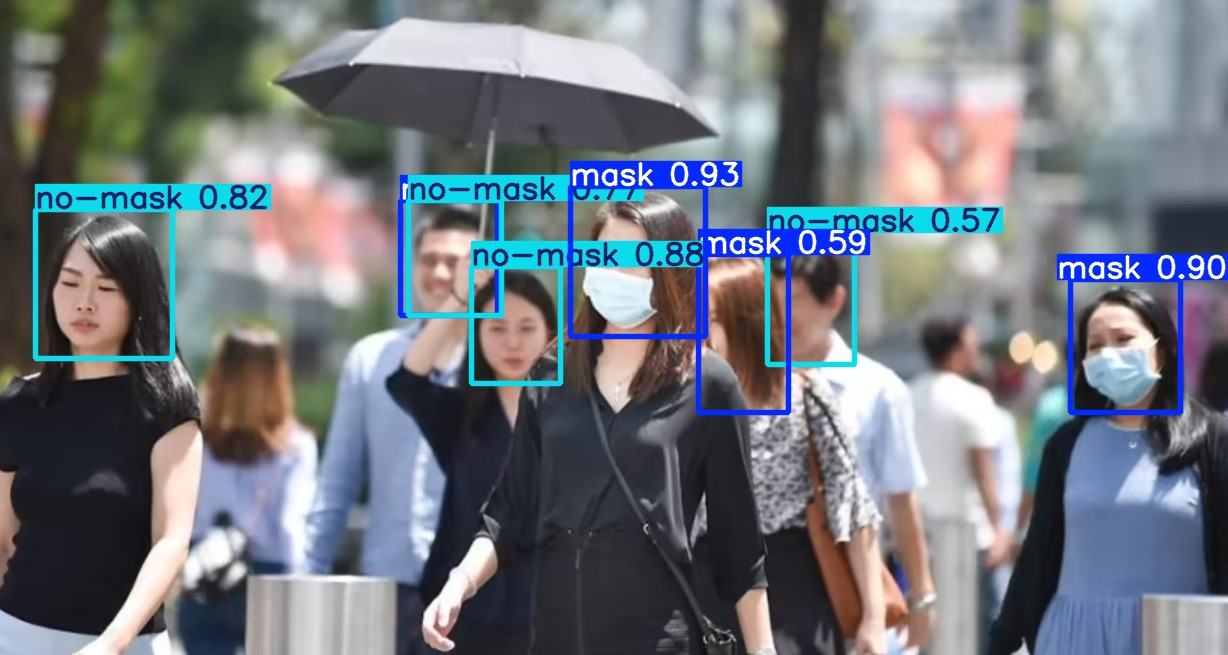

In [31]:
from IPython.display import Image
Image(filename=r'C:\Users\jinan\OneDrive\Documents\A5_DIA2\ML_CV\Projet\yolov5\runs\detect\exp5\ImageTest.jpg', width=640)

## **Performance evaluation**

### **On validation set**

In [32]:
!python C:/Users/jinan/OneDrive/Documents/A5_DIA2/ML_CV/Projet/yolov5/val.py --data C:/Users/jinan/OneDrive/Documents/A5_DIA2/ML_CV/Projet/mask_dataset/face-mask.yaml \
              --weights runs/train/exp/weights/best.pt

#METRICS : Précision P, Rappel R, mAP (Moyenne de la précision pour toutes les classes)

val: data=C:/Users/jinan/OneDrive/Documents/A5_DIA2/ML_CV/Projet/mask_dataset/face-mask.yaml, weights=['runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs\val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5  v7.0-392-gf003c3df Python-3.12.0 torch-2.5.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs

val: Scanning C:\Users\jinan\OneDrive\Documents\A5_DIA2\ML_CV\Projet\mask_dataset\valid\labels.cache... 29 images, 0 backgrounds, 0 corrupt: 100%|██████████| 29/29 [00:00<?, ?it/s]
val: Scanning C:\Users\jinan\OneDrive\Documents\A5_DIA2\ML_CV\Projet\mask_dataset\valid\labels.cache... 29 images, 0 backgrounds, 0 corrupt: 100%|██████████| 29/29 [00:00<?, ?it/s]

                 Class     Images  Instances          P      

#### Confusion Matrix Heatmap

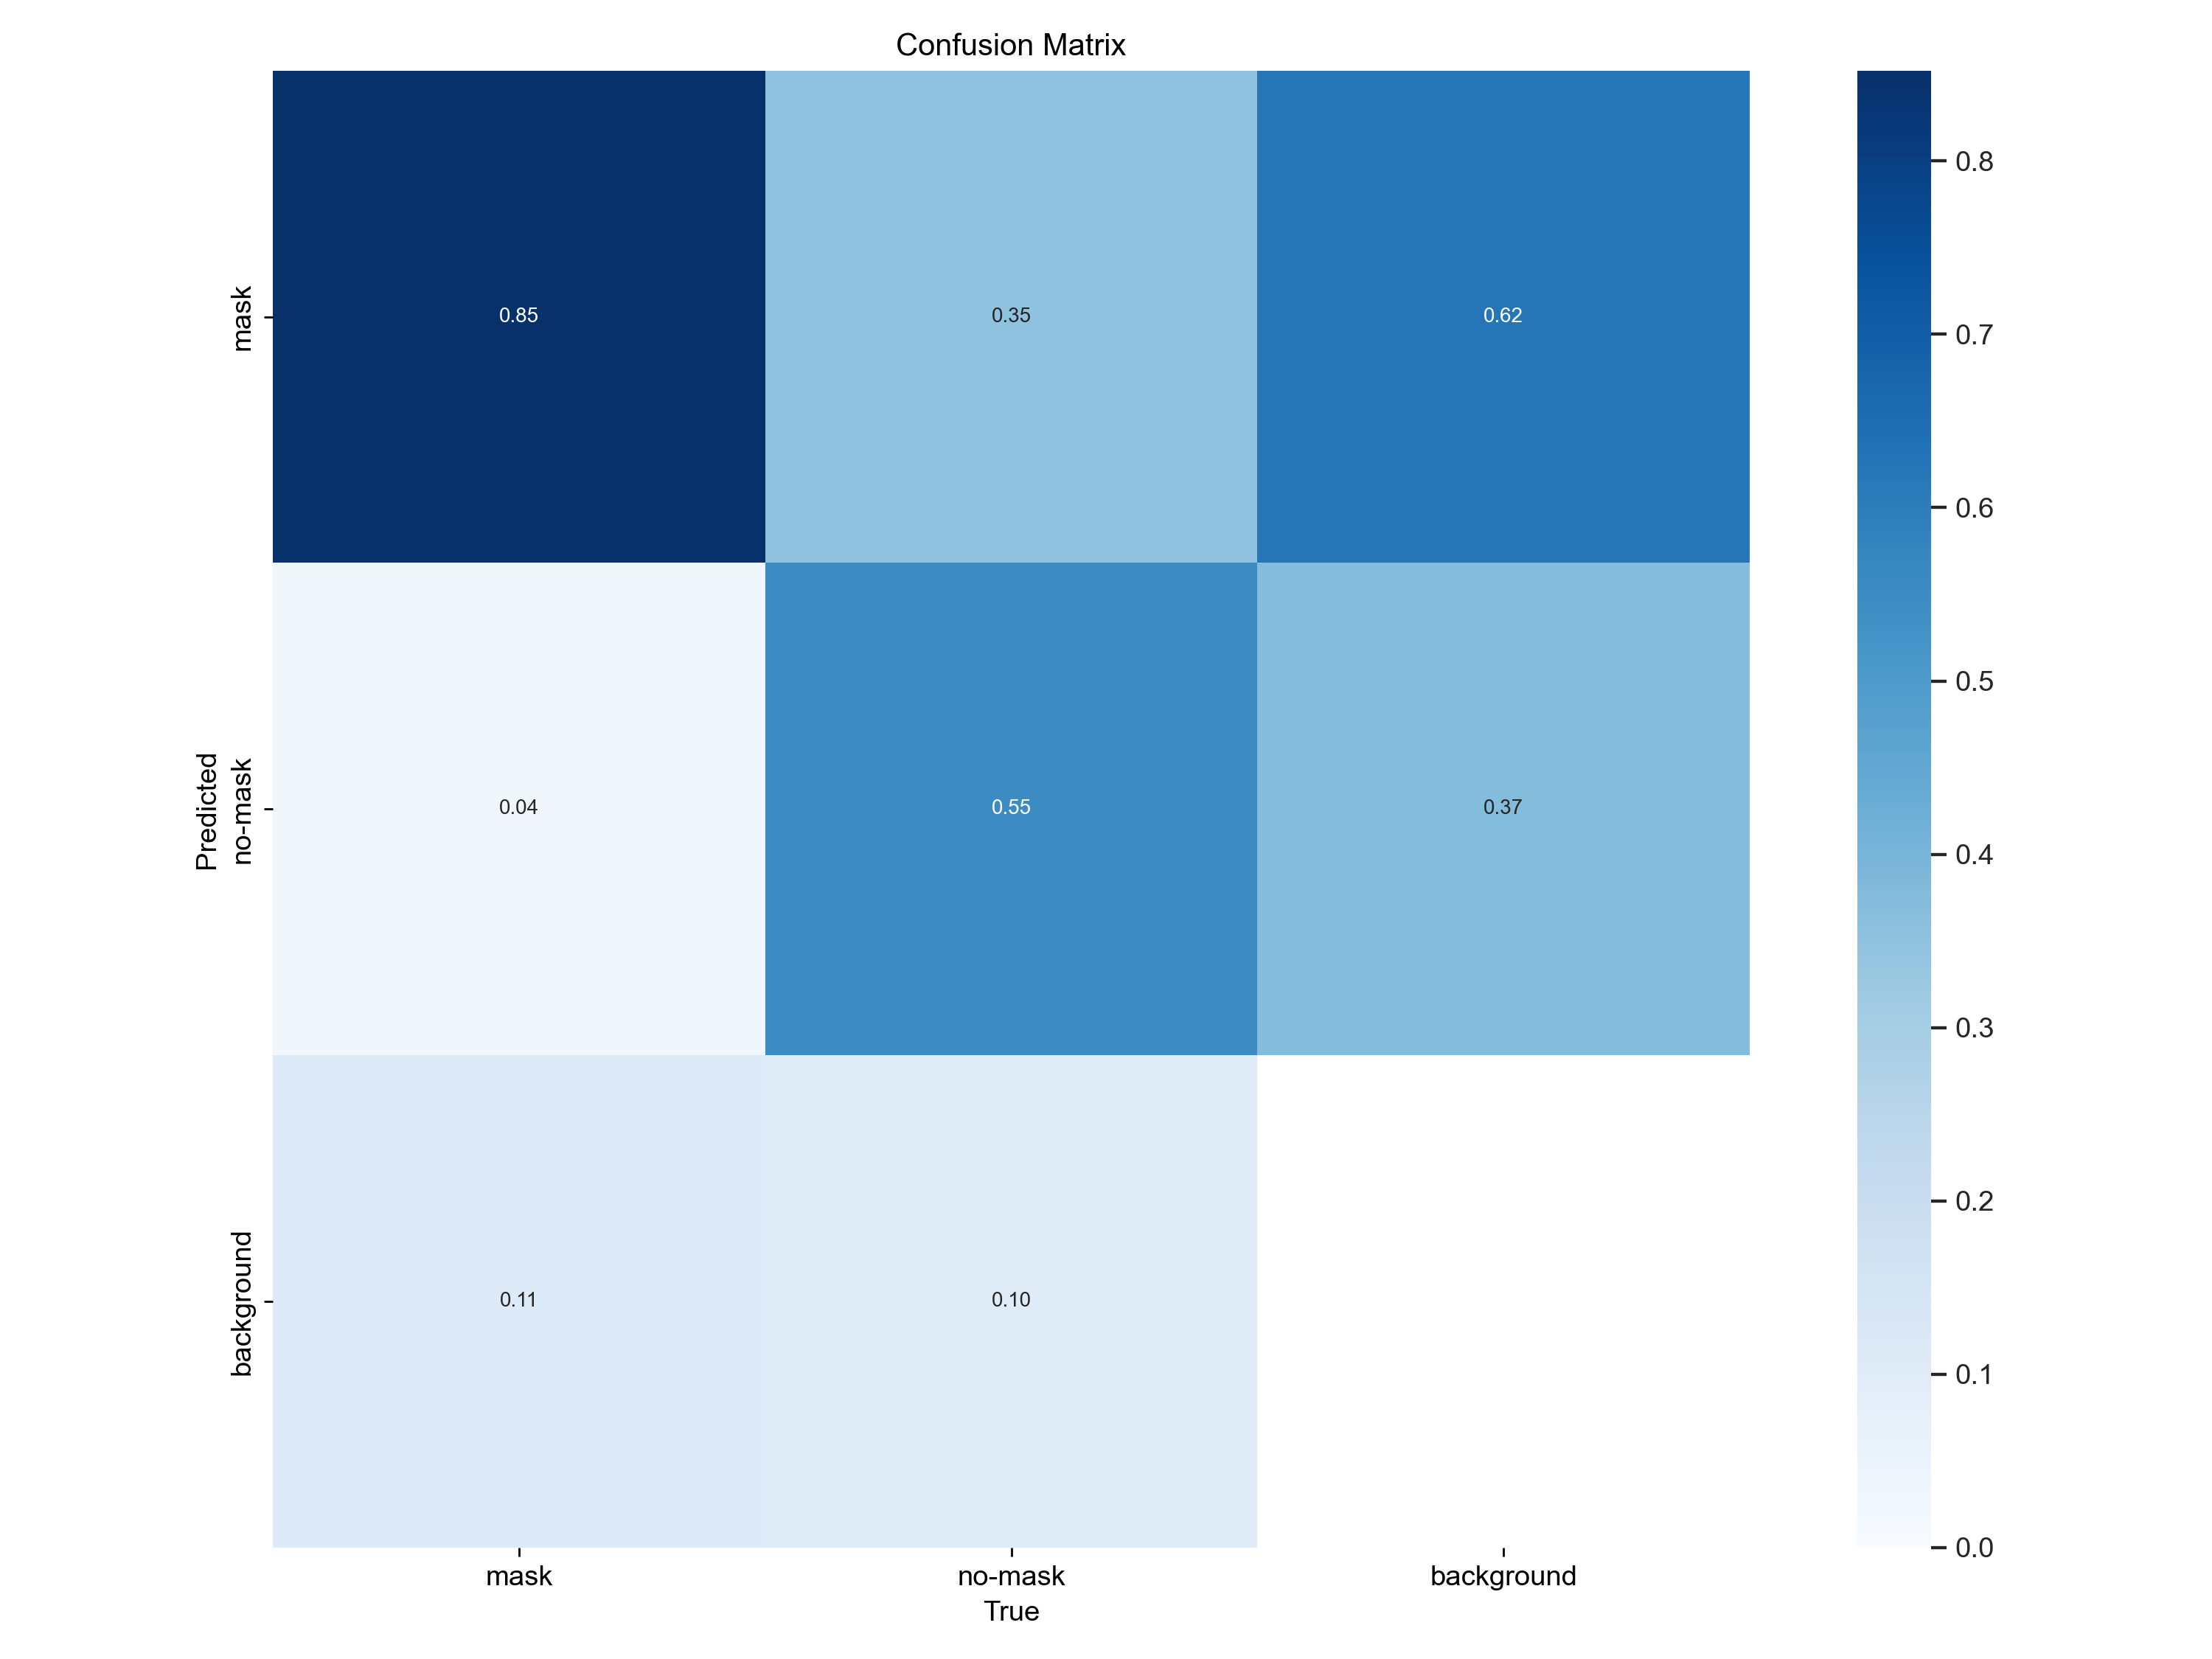

In [2]:
from IPython.display import Image, display

confusion_matrix_path = "C:/Users/jinan/OneDrive/Documents/A5_DIA2/ML_CV/Projet/yolov5/runs/val/exp/confusion_matrix.png"
display(Image(filename=confusion_matrix_path, width=800))


####Bar Chart : Precision, Recall, mAP

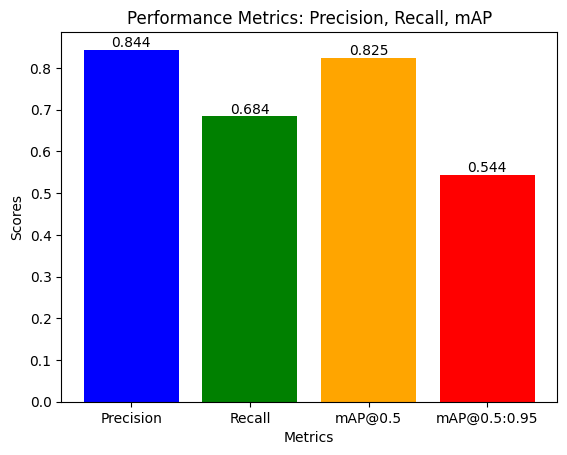

In [4]:
import matplotlib.pyplot as plt

metrics = ['Precision', 'Recall', 'mAP@0.5', 'mAP@0.5:0.95']
values = [0.844,  0.684, 0.825, 0.544]

bars = plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.3f}', ha='center', va='bottom')

plt.title('Performance Metrics: Precision, Recall, mAP')
plt.ylabel('Scores')
plt.xlabel('Metrics')
plt.show()


### **On test set**

In [37]:
!python C:/Users/jinan/OneDrive/Documents/A5_DIA2/ML_CV/Projet/yolov5/val.py --data C:/Users/jinan/OneDrive/Documents/A5_DIA2/ML_CV/Projet/mask_dataset/face-mask.yaml \
              --weights runs/train/exp/weights/best.pt --task test

val: data=C:/Users/jinan/OneDrive/Documents/A5_DIA2/ML_CV/Projet/mask_dataset/face-mask.yaml, weights=['runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs\val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5  v7.0-392-gf003c3df Python-3.12.0 torch-2.5.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs

test: Scanning C:\Users\jinan\OneDrive\Documents\A5_DIA2\ML_CV\Projet\mask_dataset\test\labels...:   0%|          | 0/15 [00:00<?, ?it/s]
test: Scanning C:\Users\jinan\OneDrive\Documents\A5_DIA2\ML_CV\Projet\mask_dataset\test\labels... 1 images, 0 backgrounds, 0 corrupt:   7%|▋         | 1/15 [00:27<06:25, 27.53s/it]
test: Scanning C:\Users\jinan\OneDrive\Documents\A5_DIA2\ML_CV\Projet\mask_dataset\test\labels... 15 ima

#### Confusion Matrix Heatmap

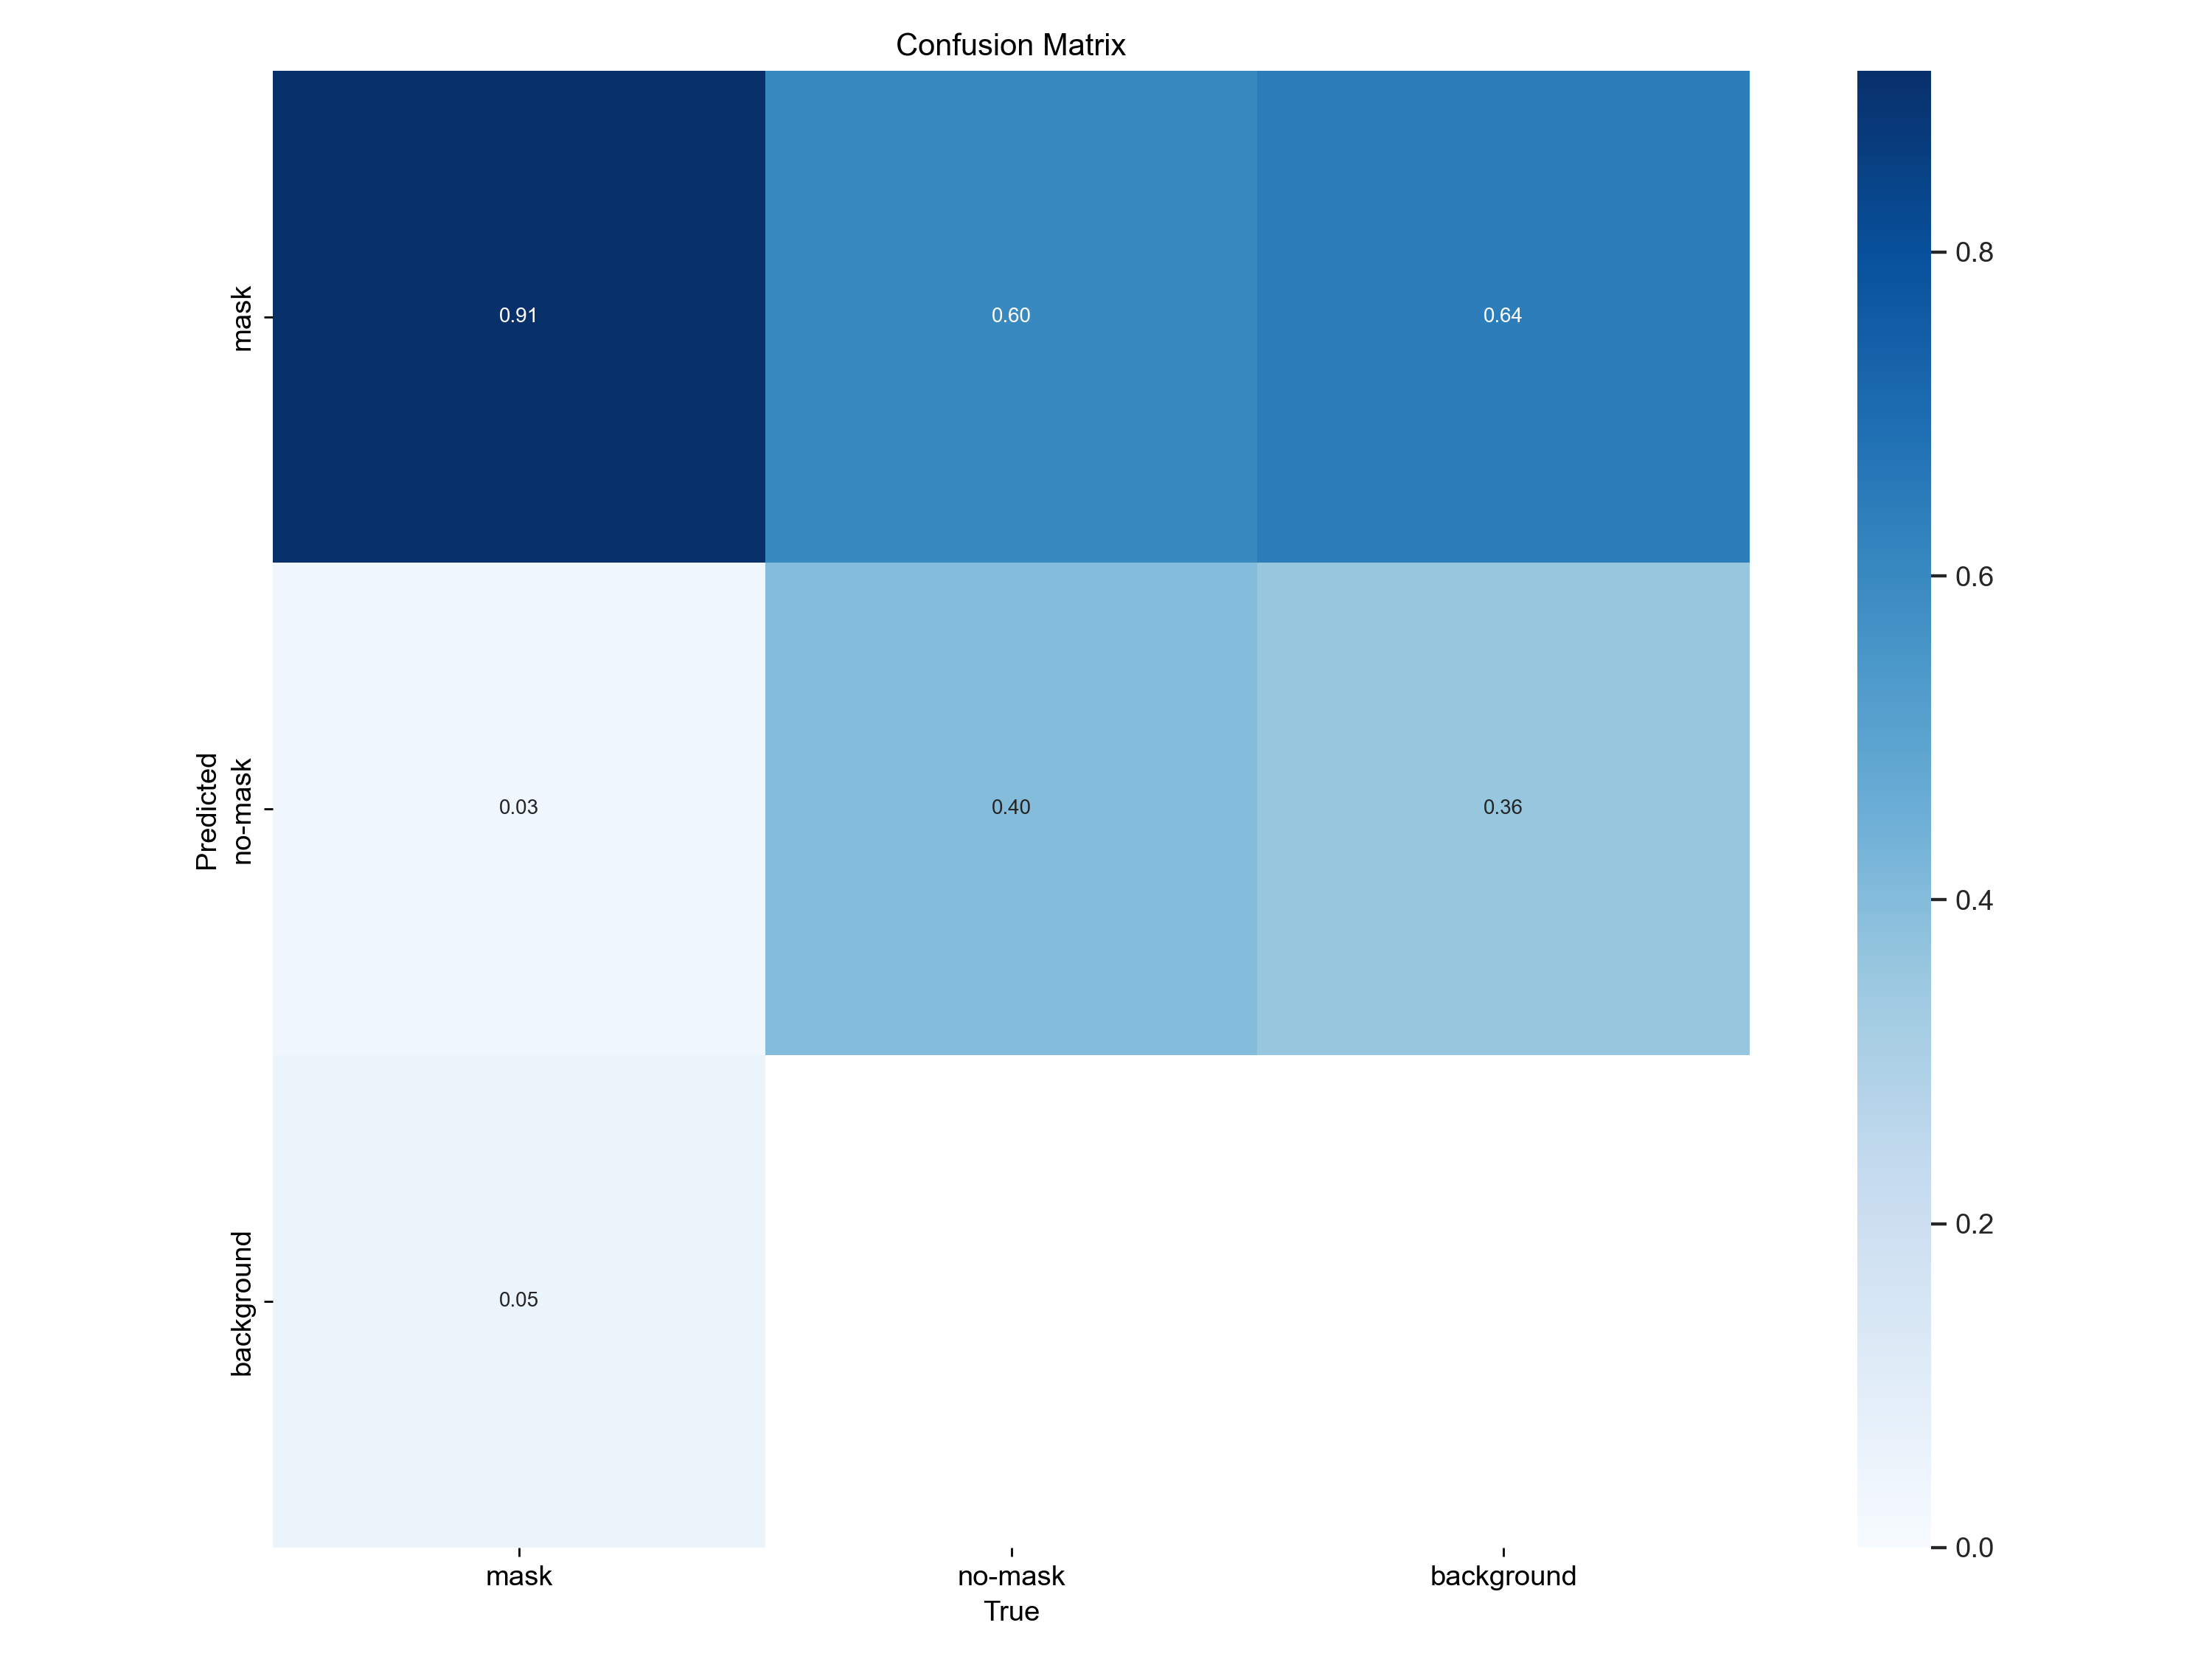

In [3]:
from IPython.display import Image, display

confusion_matrix_path = r"C:\Users\jinan\OneDrive\Documents\A5_DIA2\ML_CV\Projet\yolov5\runs\val\exp3\confusion_matrix.png"
display(Image(filename=confusion_matrix_path, width=800))


####Bar Chart : Precision, Recall, mAP

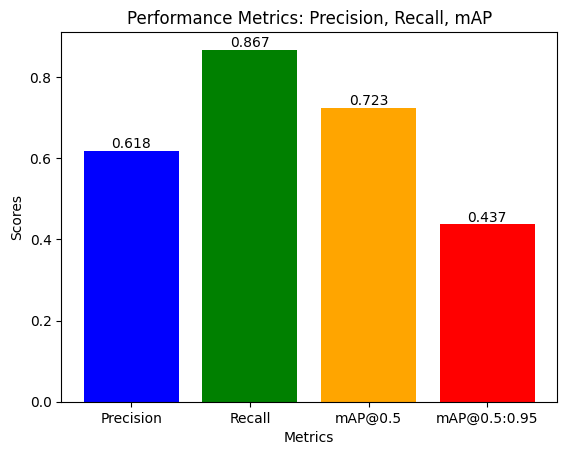

In [5]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Precision', 'Recall', 'mAP@0.5', 'mAP@0.5:0.95']
values = [0.618, 0.867, 0.723, 0.437]

bars = plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.3f}', ha='center', va='bottom')

plt.title('Performance Metrics: Precision, Recall, mAP')
plt.ylabel('Scores')
plt.xlabel('Metrics')
plt.show()


##**Détection sur une vidéo**

In [2]:
!python C:/Users/jinan/OneDrive/Documents/A5_DIA2/ML_CV/Projet/yolov5/detect.py --source C:/Users/jinan/OneDrive/Documents/A5_DIA2/ML_CV/Projet/VideoMask.mp4 \
--weights C:/Users/jinan/OneDrive/Documents/A5_DIA2/ML_CV/Projet/yolov5/runs/train/exp/weights/best.pt \
--img 640 --conf 0.5

detect: weights=['C:/Users/jinan/OneDrive/Documents/A5_DIA2/ML_CV/Projet/yolov5/runs/train/exp/weights/best.pt'], source=C:/Users/jinan/OneDrive/Documents/A5_DIA2/ML_CV/Projet/VideoMask.mp4, data=yolov5\data\coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5\runs\detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  v7.0-392-gf003c3df Python-3.12.0 torch-2.5.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
video 1/1 (1/334) C:\Users\jinan\OneDrive\Documents\A5_DIA2\ML_CV\Projet\VideoMask.mp4: 384x640 2 masks, 2 no-masks, 1258.7ms
video 1/1 (2/334) C:\Users\jinan\OneDrive\Documents\A5_DIA2\ML_CV\Projet\VideoMask.mp4: 384x

In [3]:
#Download the video with the predictions 

import os

video_path = os.path.join("yolov5", "runs", "detect", "exp8", "VideoMask.mp4")
print(f"Video saved at: {os.path.abspath(video_path)}")


Video saved at: c:\Users\jinan\OneDrive\Documents\A5_DIA2\ML_CV\Projet\yolov5\runs\detect\exp8\VideoMask.mp4


In [5]:
import cv2
from IPython.display import display, Image

# Path to the video
video_path = "yolov5/runs/detect/exp8/VideoMask.mp4"

# Open the video
cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convert BGR to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Display the frame
    cv2.imshow("Annotated Video", frame)
    
    # Stop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
